# Part 3 - Clustering using both image and text

In [ ]:
!pip install datasets transformers numpy pandas Pillow matplotlib
!pip install torch tqdm scipy
!pip install git+https://github.com/openai/CLIP.git
!pip install plotly umap-learn

In [2]:
from datasets import load_dataset
from transformers import CLIPProcessor, CLIPModel
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import clip
import torch
from tqdm import tqdm
from scipy.special import softmax
import plotly.express as px
import plotly.graph_objects as go
from sklearn.manifold import TSNE

In [3]:
import requests

# download Pokemon.csv
url = "https://raw.githubusercontent.com/lgreski/pokemonData/master/Pokemon.csv"
response = requests.get(url)

if response.status_code == 200:
    with open("Pokemon.csv", "wb") as f:
        f.write(response.content)
    print("CSV file downloaded successfully")
else:
    print("Failed to download CSV file. Status code:", response.status_code)

# download image data
!pip install -q opendatasets

import opendatasets as od
od.download('https://www.kaggle.com/datasets/hlrhegemony/pokemon-image-dataset') # insert your kaggle username and key

CSV file downloaded successfully
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ylc500224
Your Kaggle Key: ··········


100%|██████████| 57.9M/57.9M [00:00<00:00, 129MB/s]


In [4]:
# load csv file and image paths to construct pokedex, use type_to_load=None to load all types, else use a list of types 1 to load
def construct_pokedex(csv_path='Pokemon.csv', image_dir='./pokemon-image-dataset/images', type_to_load=None):
    pokedex = pd.read_csv(csv_path)
    image_paths = []

    for pokemon_name in pokedex["Name"]:
        imgs = glob(f"{image_dir}/{pokemon_name}/0.jpg")
        if len(imgs) > 0:
            image_paths.append(imgs[0])
        else:
            image_paths.append(None)

    pokedex["image_path"] = image_paths
    pokedex = pokedex[pokedex["image_path"].notna()].reset_index(drop=True)

    # only keep pokemon with distinct id
    ids, id_counts = np.unique(pokedex["ID"], return_counts=True)
    ids, id_counts = np.array(ids), np.array(id_counts)
    keep_ids = ids[id_counts == 1]

    pokedex = pokedex[pokedex["ID"].isin(keep_ids)].reset_index(drop=True)
    pokedex["Type2"] = pokedex["Type2"].str.strip()
    if type_to_load is not None:
        pokedex = pokedex[pokedex["Type1"].isin(type_to_load)].reset_index(drop=True)
    return pokedex

# load clip model
def load_clip_model():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-L/14", device=device)
    return model, preprocess, device

# inference clip model on a list of image path
def clip_inference_image(model, preprocess, image_paths, device):
    image_embeddings = []
    with torch.no_grad():
        for img_path in tqdm(image_paths):
            img = Image.open(img_path)
            img_preprocessed = preprocess(img).unsqueeze(0).to(device)
            image_embedding = model.encode_image(img_preprocessed).detach().cpu().numpy()
            image_embeddings += [image_embedding]

    image_embeddings = np.concatenate(image_embeddings, axis=0)
    image_embeddings /= np.linalg.norm(image_embeddings, axis=-1, keepdims=True)
    return image_embeddings

# inference clip model on a list of texts
def clip_inference_text(model, preprocess, texts, device):
    with torch.no_grad():
        text_embeddings = model.encode_text(clip.tokenize(texts).to(device)).detach().cpu().numpy()
    text_embeddings /= np.linalg.norm(text_embeddings, axis=-1, keepdims=True)
    return text_embeddings

# compute similarity of texts to each image
def compute_similarity_text_to_image(image_embeddings, text_embeddings):
    similarity = softmax((100.0 * image_embeddings @ text_embeddings.T), axis=-1)
    return similarity

# compute similarity of iamges to each text
def compute_similarity_image_to_text(image_embeddings, text_embeddings):
    similarity = softmax((100.0 * image_embeddings @ text_embeddings.T), axis=0)
    return similarity

# Use TSNE to project CLIP embeddings to 2D space
def umap_projection(image_embeddings, n_neighbors=15, min_dist=0.1, metric='cosine'):
    distance_matrix = np.zeros((image_embeddings.shape[0], image_embeddings.shape[0]))
    for i in range(image_embeddings.shape[0]):
        for j in range(image_embeddings.shape[0]):
            if i == j:
                distance_matrix[i, j] = 1
            else:
                distance_matrix[i, j] = np.dot(image_embeddings[i], image_embeddings[j])
    distance_matrix = 1 - distance_matrix
    reducer = TSNE(n_components=2, metric="precomputed", init="random", random_state=42)
    visualization_data = reducer.fit_transform(distance_matrix)
    return visualization_data

In [5]:
# construct pokedex
pokedex = construct_pokedex()
pokedex.head()

,ID,Name,Form,Type1,Type2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,image_path
0,1,Bulbasaur,,Grass,Poison,318,45,49,49,65,65,45,1,./pokemon-image-dataset/images/Bulbasaur/0.jpg
1,2,Ivysaur,,Grass,Poison,405,60,62,63,80,80,60,1,./pokemon-image-dataset/images/Ivysaur/0.jpg
2,4,Charmander,,Fire,,309,39,52,43,60,50,65,1,./pokemon-image-dataset/images/Charmander/0.jpg
3,5,Charmeleon,,Fire,,405,58,64,58,80,65,80,1,./pokemon-image-dataset/images/Charmeleon/0.jpg
4,7,Squirtle,,Water,,314,44,48,65,50,64,43,1,./pokemon-image-dataset/images/Squirtle/0.jpg


In [6]:
# load model
model, preprocess, device = load_clip_model()

100%|███████████████████████████████████████| 890M/890M [00:09<00:00, 96.6MiB/s]


## QUESTION 26

- Find the top five most relevant Pokemon for type Bug, Fire and Grass.
- Plot the query, the name of the Pokemon and its first and second type
- Repeat this process for Pokemon of Dark and Dragon types
- Assess the effectiveness of your queries in these cases as well and try to explain any differences.
  - Anwser:
  - After testing, I got better performance under the queries `XYZ type Pokemon`. Because when using the CLIP model for inference on Pokémon data without fine-tuning, the model relies on visual similarities rather than domain-specific knowledge. This approach can lead to inaccuracies, such as classifying Pokémon based on their appearance rather than their actual type. The model's effectiveness is limited by its generalist training, which probably include few or zero specific Pokémon-related data, resulting in a **domain shift** between training and inference tasks. Thus, while CLIP can identify visually similar Pokémon, it may not accurately classify them. That's why we should specify `Pokemon` term in our queries.
  
  - For example, in cases involving queries "type dragon," the model tends to identify Pokémon based on visual characteristics associated with dragons, rather than accurately recognizing the true dragon type. This reflects the model's reliance on visual similarity over precise domain-specific classification.


In [7]:
# build image embeddings
image_paths = pokedex.image_path.to_list()
image_embeddings = clip_inference_image(model, preprocess, image_paths, device)

100%|██████████| 753/753 [00:32<00:00, 23.39it/s]


q='bug type Pokemon'


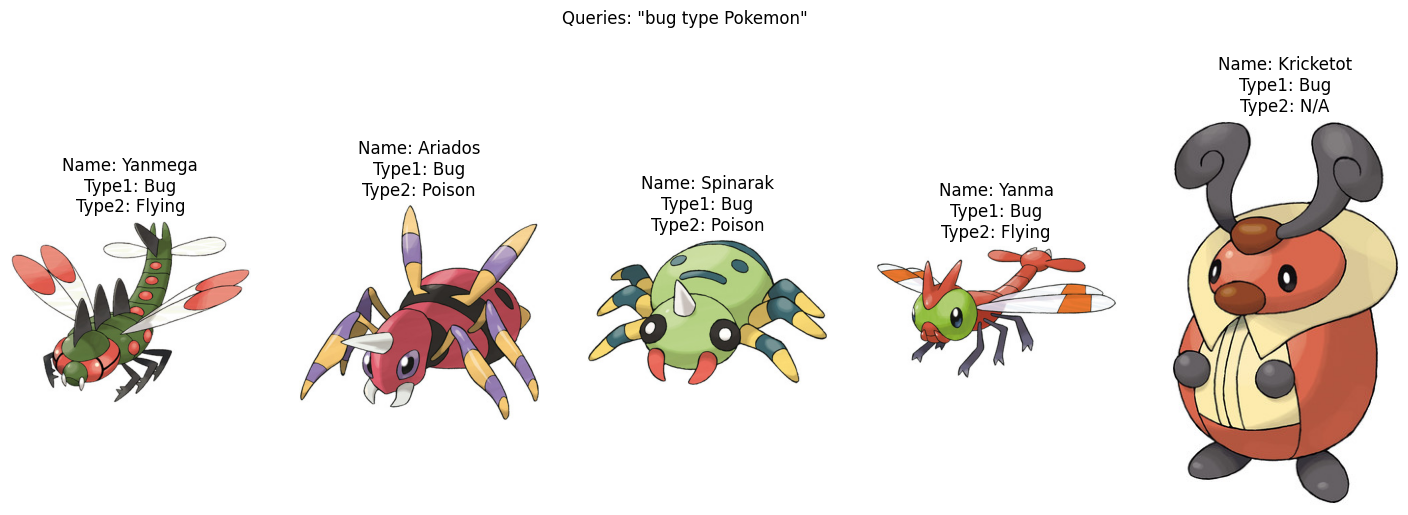

q='fire type Pokemon'


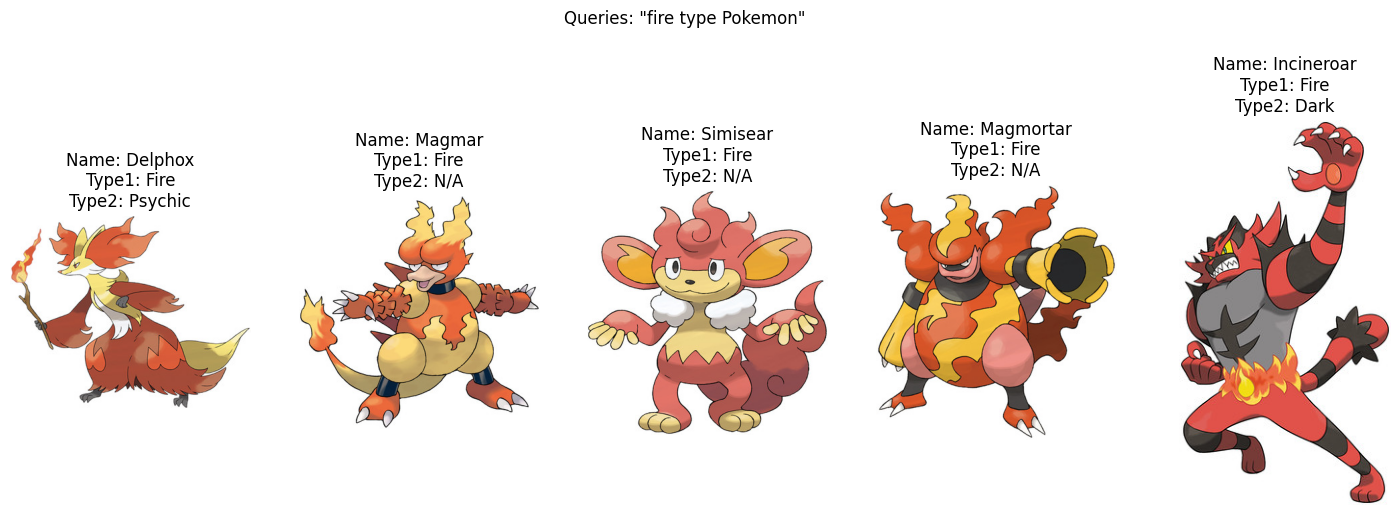

q='grass type Pokemon'


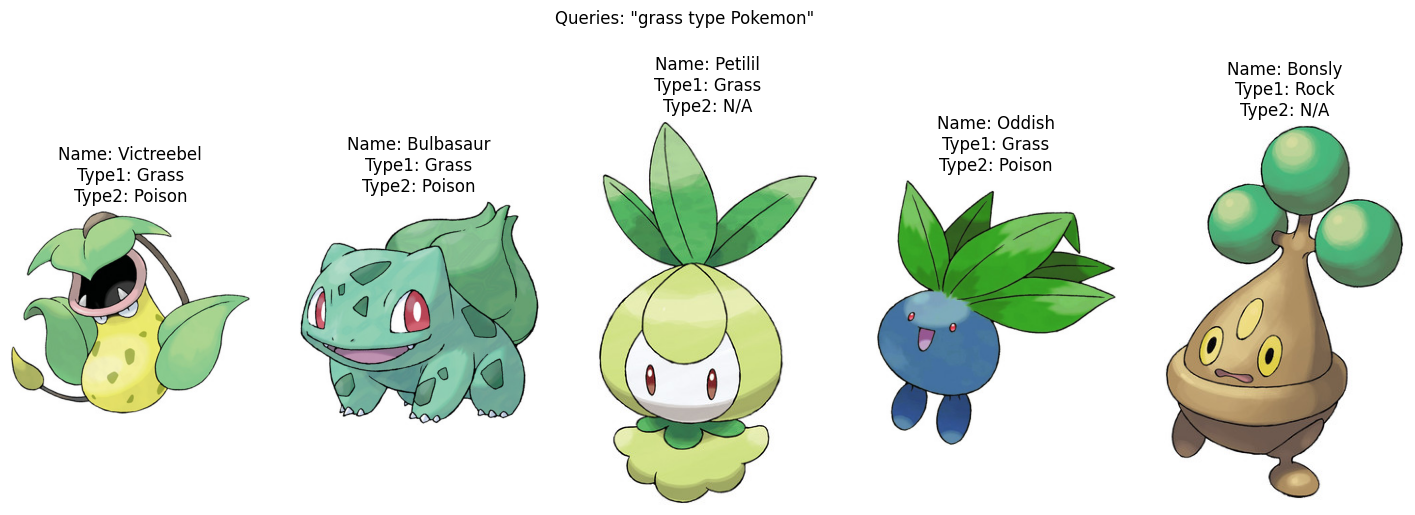

In [8]:
# queries = ["type: Bug", "bug type", "electric type", "Pokemon with fire abilities"]
queries = ["bug type Pokemon", "fire type Pokemon", "grass type Pokemon"]

# build text embeddings
text_embeddings = clip_inference_text(model, preprocess, queries, device) # shape: [len(queries),  ]

for i, q in enumerate(queries):
  print(f'{q=}')

  # find the top relevant
  similarity = compute_similarity_image_to_text(image_embeddings, text_embeddings[i:i+1])
  top_five = np.argsort(similarity[:, 0])[::-1][:5]
  # print(f'{top_five=}')

  # plot
  fig, axs = plt.subplots(1, 5, figsize=(18, 5))
  fig.suptitle(f'Queries: "{q}"', y = 1.1)

  for i, idx in enumerate(top_five):
      img_path = pokedex.iloc[idx]['image_path']
      img = Image.open(img_path)
      axs[i].imshow(img)
      axs[i].set_title(f"Name: {pokedex.iloc[idx]['Name']}\nType1: {pokedex.iloc[idx]['Type1']}\nType2: {pokedex.iloc[idx]['Type2'] if pokedex.iloc[idx]['Type2'] else 'N/A'}")

      axs[i].axis('off')

  plt.show()

q='dark type Pokemon'
top_five=array([665,  59, 144, 391, 277])


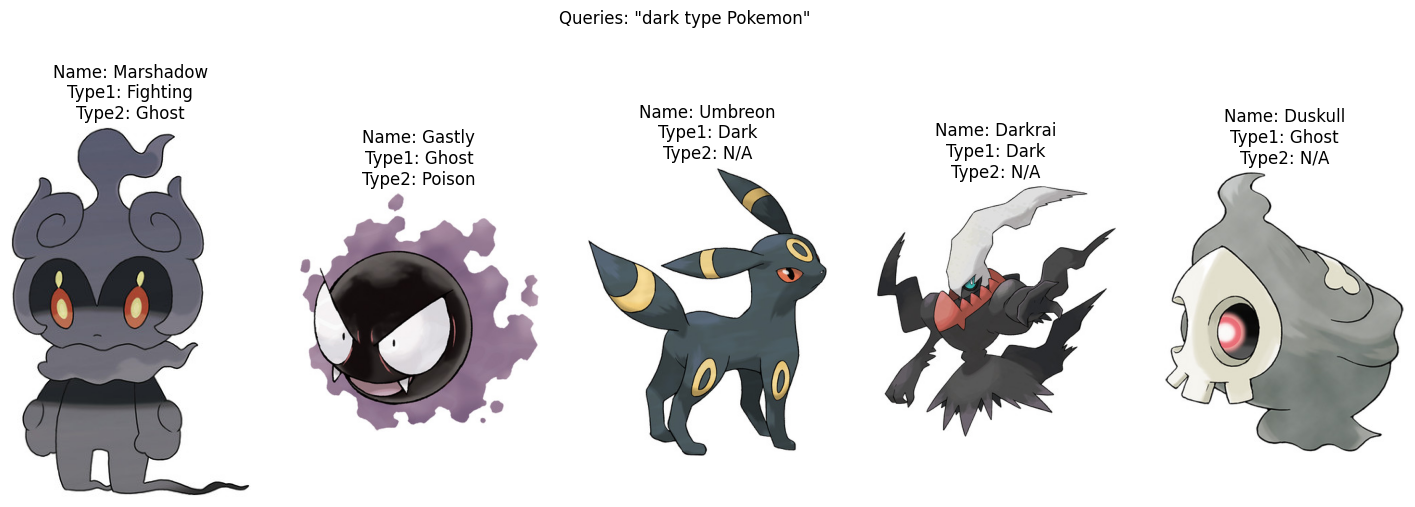

q='dragon type Pokemon'
top_five=array([100, 167, 510, 523, 191])


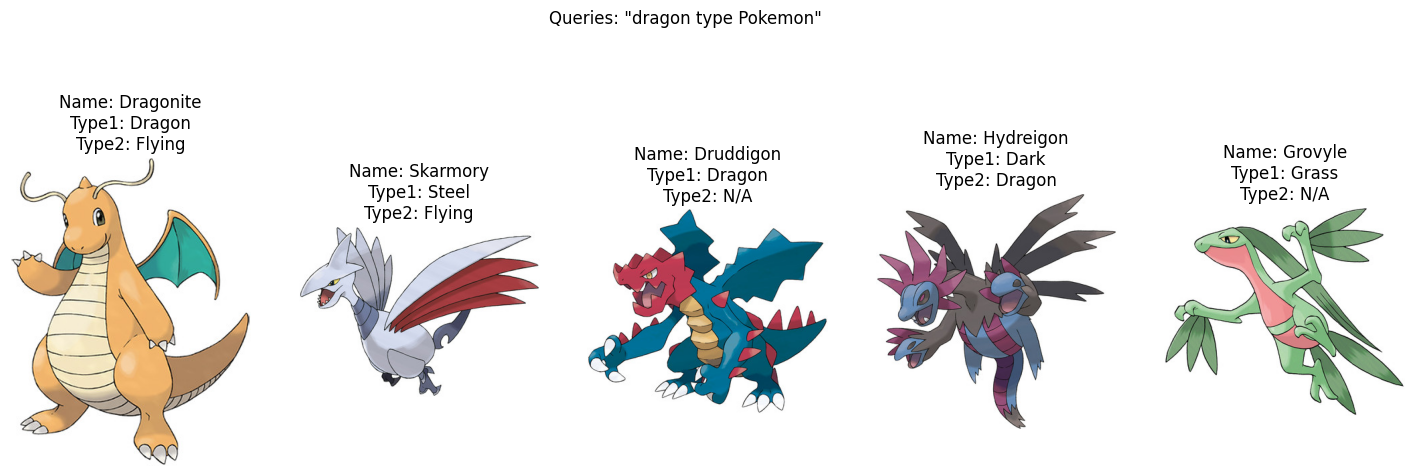

In [9]:
queries = ["dark type Pokemon", "dragon type Pokemon"]

# build text embeddings
text_embeddings = clip_inference_text(model, preprocess, queries, device) # shape: [len(queries),  ]

for i, q in enumerate(queries):
  print(f'{q=}')

  # find the top relevant
  similarity = compute_similarity_image_to_text(image_embeddings, text_embeddings[i:i+1])
  top_five = np.argsort(similarity[:, 0])[::-1][:5]
  print(f'{top_five=}')

  # Plot results
  fig, axs = plt.subplots(1, 5, figsize=(18, 5))
  fig.suptitle(f'Queries: "{q}"', y = 1.1)

  for i, idx in enumerate(top_five):
      img_path = pokedex.iloc[idx]['image_path']
      img = Image.open(img_path)
      axs[i].imshow(img)
      axs[i].set_title(f"Name: {pokedex.iloc[idx]['Name']}\nType1: {pokedex.iloc[idx]['Type1']}\nType2: {pokedex.iloc[idx]['Type2'] if pokedex.iloc[idx]['Type2'] else 'N/A'}")

      axs[i].axis('off')

  plt.show()

## QUESTION 27:

Randomly select 10 Pokemon images from the dataset and use CLIP to find the most relevant types. For each selected Pokemon, please plot it and indicate:

- its name and first and second type;
- the five most relevant types predicted by CLIP and their predicted probabilities.

In [10]:
# build pokemon types embedding
pokemon_types = [i for i in set(pokedex['Type1'].values).union(set(pokedex['Type2'].values)) if i != '']
text_queries = [f"type: {poke_type}" for poke_type in pokemon_types]
text_embeddings = clip_inference_text(model, preprocess, text_queries, device)

100%|██████████| 1/1 [00:00<00:00, 36.59it/s]


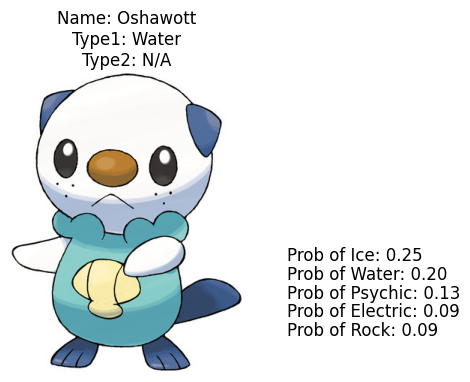

100%|██████████| 1/1 [00:00<00:00, 32.50it/s]


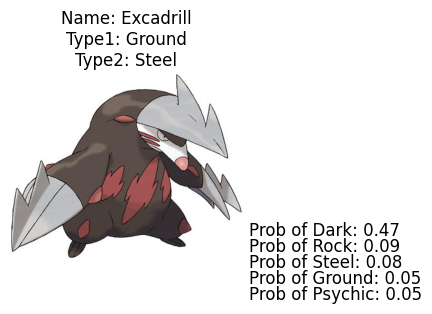

100%|██████████| 1/1 [00:00<00:00, 36.27it/s]


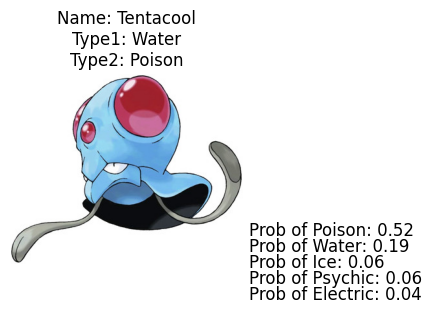

100%|██████████| 1/1 [00:00<00:00, 27.46it/s]


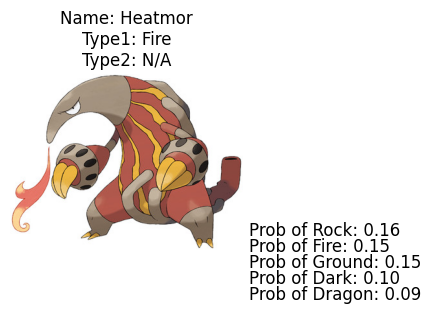

100%|██████████| 1/1 [00:00<00:00, 29.46it/s]


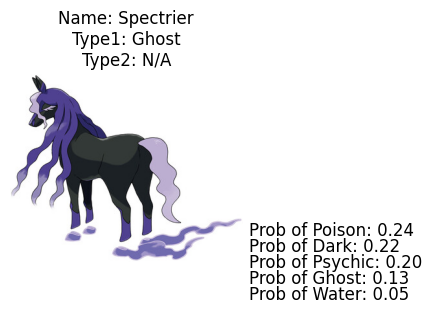

100%|██████████| 1/1 [00:00<00:00, 28.64it/s]


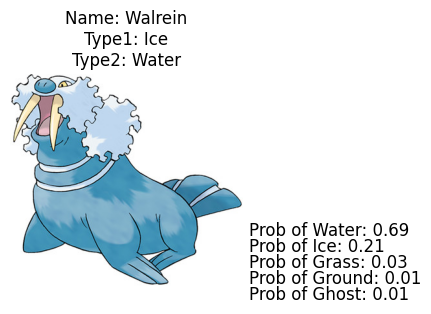

100%|██████████| 1/1 [00:00<00:00, 30.52it/s]


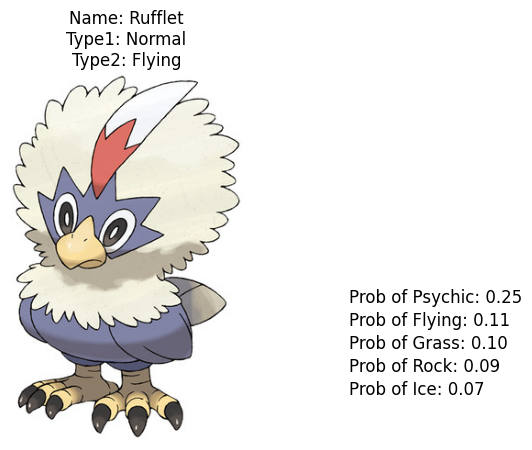

100%|██████████| 1/1 [00:00<00:00, 31.44it/s]


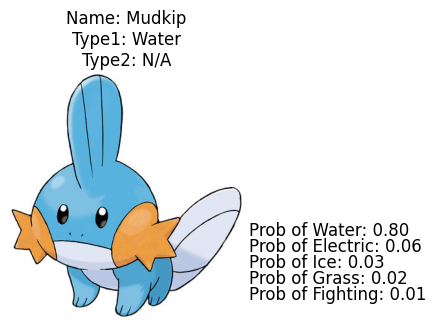

100%|██████████| 1/1 [00:00<00:00, 22.97it/s]


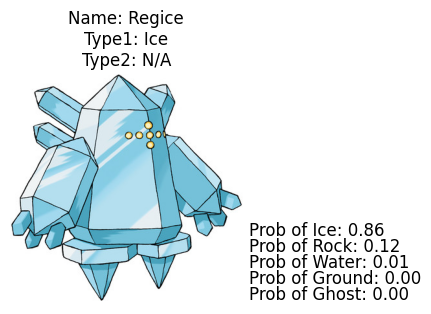

100%|██████████| 1/1 [00:00<00:00, 30.86it/s]


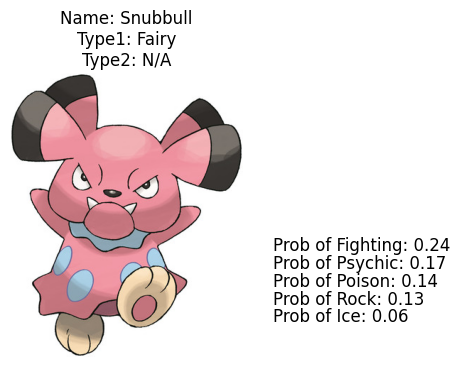

In [11]:
# randomly select 10 pokemons
selected_pokemons = pokedex.sample(n = 10, random_state = 22)

for i, row in selected_pokemons.iterrows():
    image_path = row['image_path']
    img = Image.open(image_path)

    # get image embedding
    img_preprocessed = preprocess(img).unsqueeze(0).to(device)
    image_embedding = clip_inference_image(model, preprocess, [image_path], device)

    # compute similarity
    similarity = compute_similarity_text_to_image(image_embedding, text_embeddings) # shape: [batch_size, len(pokemon_types)]
    top_types_indices = np.argsort(similarity[0])[::-1][:5]
    top_types = [pokemon_types[i] for i in top_types_indices]
    top_probs = [similarity[0][i] for i in top_types_indices]

    # plot
    plt.figure(figsize=(3, 7))
    plt.imshow(img)
    plt.title(f"Name: {row['Name']}\nType1: {row['Type1']}\nType2: {row['Type2'] if row['Type2'] else 'N/A'}", )
    plt.axis('off')

    # display top 5 types and probabilities
    for i, (pokemon_type, prob) in enumerate(zip(top_types, top_probs)):
        plt.text(370, 250 + i*25, f"Prob of {pokemon_type}: {prob:.2f}", fontsize=12)

    plt.show()

 ## QUESTION 28:

 - Use t-SNE to visualize image clusters, specifically for Pokemon types Bug, Fire, and Grass
 - For the visualization, color-code each point based on its first type type 1 using the ’color’ argument, and label each point with the Pokemon’s name and types using ’hover name’.
 - Analyze it and discuss whether the clustering of Pokemon types make sense to you.
  - Answer: According to the below figure, it appears that there are three well-defined clusters. The distribution shows Bug types (blue points) primarily in the upper left corner of the plot, Grass types (green points) in the upper right corner, and a distinct cluster of Fire types (red points) in the lower center of the plot. However, the central region of the plot is messier, with a greater degree of overlap. This may suggest that their visual features are more varied, or they share more common visual attributes with each other. To sum up, the types are mostly well-clustered with little overlap, it suggests that the model used to generate embeddings is effective in distinguishing the visual and conceptual features of these three Pokemon types. The slight overlap observed may be attributed to the presence of shared attributes among certain Pokemon across these types.


In [99]:
# build image embeddings
filtered_pokedex = pokedex[pokedex["Type1"].isin(["Bug", "Fire", "Grass"])]
image_paths = filtered_pokedex["image_path"].tolist()
image_embeddings = clip_inference_image(model, preprocess, image_paths, device)

100%|██████████| 192/192 [00:04<00:00, 42.46it/s]


In [108]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30).fit_transform(image_embeddings)

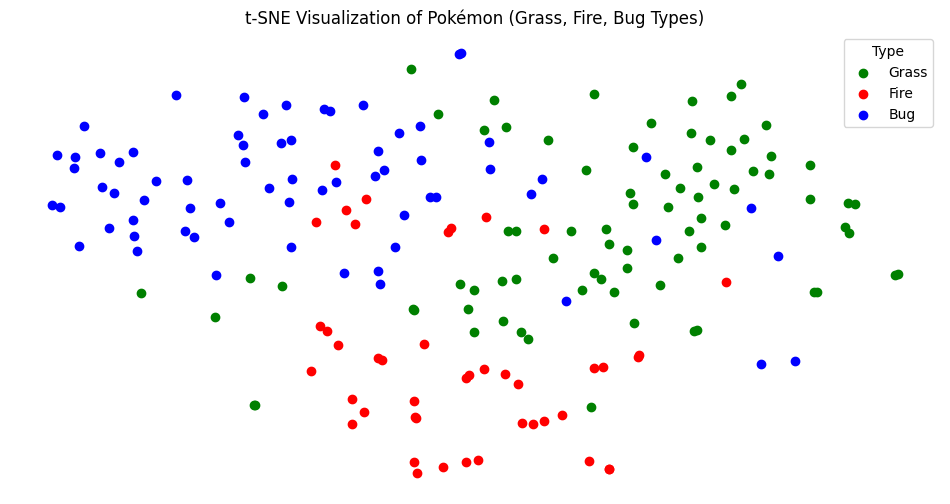

In [111]:
import matplotlib.pyplot as plt

# create a color map based on unique Type1 values
unique_types = ['Grass', 'Fire', 'Bug']
type_colors = ['Green', 'Red', 'Blue']

# plot the figure
plt.figure(figsize=(12, 6))

for poke_type, color in zip(unique_types, type_colors):
    # filter the points belonging to the current type
    type_mask = filtered_pokedex['Type1'] == poke_type
    # plot the points with the filtered indices and assign a label for the legend
    plt.scatter(x=X_embedded[type_mask, 0], y=X_embedded[type_mask, 1], c=[color], label=poke_type)

plt.legend(title='Type')
plt.title('t-SNE Visualization of Pokémon (Grass, Fire, Bug Types)') # Set title
plt.gca().set_axis_off() #  remove axis

plt.show()

In [113]:
# interaton plot
import plotly.express as px

color_codes = filtered_pokedex['Type1'].tolist()
hover_labels = 'Name: ' + filtered_pokedex['Name'] + ' (Type1: ' + filtered_pokedex['Type1'] + '; Type2: ' + filtered_pokedex['Type2'] + ')'

fig = px.scatter(x=X_embedded[:,0], y=X_embedded[:,1],
                 color=color_codes,
                 hover_name=hover_labels,
                 title='Pokémon t-SNE Visualization')

fig.show()